Step 1: Import library

In [ ]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (
    ttest_ind, 
    levene, 
    chi2_contingency, 
    skew, 
    kurtosis, 
    pearsonr, 
    f_oneway
)
import statsmodels.api as sm
from semopy import Model, calc_stats
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [3]:
df = pd.read_csv("../../Dataset/household.csv")

In [4]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2: Load data and resample to hour

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)  
      .reset_index()
)
print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 605260 → After merging followed by hour: 10234


,date,active_power,temp,feels_like,pressure,humidity,speed
0,2022-11-05 14:00:00,248.780000,24.246364,23.728182,1011.909091,38.436364,0.081818
1,2022-11-05 15:00:00,202.663333,24.302000,23.765333,1010.666667,37.366667,2.912167
2,2022-11-05 16:00:00,198.863333,24.174000,23.605833,1011.416667,36.666667,2.322667
3,2022-11-05 17:00:00,390.181667,23.485667,22.830667,1010.600000,36.083333,2.455000
4,2022-11-05 18:00:00,443.036667,21.693667,20.933333,1008.816667,38.783333,2.269500
...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000


Step 2.3: Prepare some data columns

In [ ]:
df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

Step 2.4: View data

In [7]:
df_hour

,date,active_power,temp,feels_like,pressure,humidity,speed,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,28.653167,27.250167,1013.916667,21.083333,3.781167,6,1,224.355000,248.780000,273.720891
25,2022-11-06 15:00:00,297.003333,28.226667,26.947833,1013.016667,21.516667,4.559333,6,1,163.376667,202.663333,277.651724
26,2022-11-06 16:00:00,396.440000,27.816167,26.716833,1013.250000,22.916667,4.938667,6,1,297.003333,198.863333,285.884085
27,2022-11-06 17:00:00,311.295000,25.777500,25.265667,1013.166667,24.566667,4.757667,6,1,396.440000,390.181667,282.597141
28,2022-11-06 18:00:00,443.610000,23.328667,22.383333,1011.133333,25.483333,4.779167,6,1,311.295000,443.036667,282.621030
...,...,...,...,...,...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889,4,0,235.570833,293.395455,241.304597
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322,4,0,329.995556,342.735593,243.407775
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525,4,0,393.211864,396.593220,236.618439
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000,4,0,233.649153,406.398333,235.273231


Step 3. Implement models

3.7 SARIMAX Model

3.7.1 Repair some necessary df

In [ ]:
df_model = df_hour.copy()
df_model['date'] = pd.to_datetime(df_model['date'])
df_model = df_model.set_index('date')
df_model = df_model.sort_index()
df_model = df_model.asfreq('H')
df_model = df_model.dropna()
series = df_model['active_power']
exog_vars = ['temp','humidity','pressure','speed','ap_lag_1h','ap_lag_24h','ap_roll_24h']
exog = df_model[exog_vars]

print("df_model NA counts:")
print(df_model[exog_vars].isna().sum())

print("\ndf_model rows:", len(df_model))
print("df_model inferred freq:", pd.infer_freq(df_model.index))

df_model NA counts:
temp           0
humidity       0
pressure       0
speed          0
ap_lag_1h      0
ap_lag_24h     0
ap_roll_24h    0
dtype: int64

df_model rows: 10112
df_model inferred freq: None


3.7.2 Detect Seasonality (S) using FFT

Top seasonality candidates (period in hours) from FFT (excluding DC / very low freq):
  Period ≈ 24.0 hours (magnitude=142254.7)
  Period ≈ 12.0 hours (magnitude=121848.7)
  Period ≈ 206.4 hours (magnitude=104227.0)
  Period ≈ 187.3 hours (magnitude=88122.1)
  Period ≈ 229.8 hours (magnitude=76889.6)


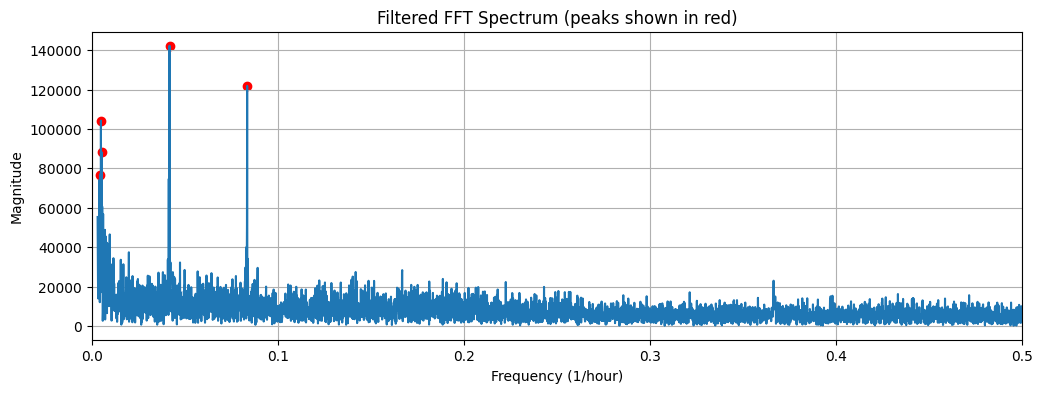


Recommendation: Should choose S = 24 because strong peak ~24h.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import find_peaks

y = series.values
y = y - np.mean(y)
n = len(y)
Y = fft(y)
freq = np.fft.fftfreq(n, d=1)             
mag = np.abs(Y)

pos_mask = freq > 0
pos_freq = freq[pos_mask]
pos_mag = mag[pos_mask]

max_period_hours = 336                                            
min_freq = 1 / max_period_hours

valid_mask = pos_freq >= min_freq
freq_filtered = pos_freq[valid_mask]
mag_filtered = pos_mag[valid_mask]

peaks_idx, _ = find_peaks(mag_filtered)
peak_mags = mag_filtered[peaks_idx]
                                    
order = np.argsort(peak_mags)[::-1]

top_k = 5
candidates = []
for i in order[:top_k]:
    f = freq_filtered[peaks_idx[i]]
    period = 1 / f
    candidates.append((period, mag_filtered[peaks_idx[i]]))

print("Top seasonality candidates (period in hours) from FFT (excluding DC / very low freq):")
for per, m in candidates:
    print(f"  Period ≈ {per:.1f} hours (magnitude={m:.1f})")

plt.figure(figsize=(12,4))
plt.plot(freq_filtered, mag_filtered)
plt.scatter([1/p for p, _ in candidates], [m for _, m in candidates], color='red')
plt.xlim(0, 0.5)                                                      
plt.xlabel("Frequency (1/hour)")
plt.ylabel("Magnitude")
plt.title("Filtered FFT Spectrum (peaks shown in red)")
plt.grid(True)
plt.show()
recommended = None
for per, _ in candidates:
    if abs(per - 24) <= 1:
        recommended = 24
        reason = "strong peak ~24h"
        break
if recommended is None:
    recommended = int(round(candidates[0][0])) if len(candidates)>0 else None
    reason = "highest FFT peak in plausible period range"
print()
if recommended:
    print(f"Recommendation: Should choose S = {recommended} because {reason}.")
else:
    print("Recommendation: No clear seasonality found in the checked range.")

3.7.3 Train / Validate / Test Split 

In [ ]:
n = len(series)

train_end = int(n * 0.80)
val_end   = int(n * 0.90)

y_train = series.iloc[:train_end]
y_val   = series.iloc[train_end:val_end]
y_test  = series.iloc[val_end:]

exog_train = exog.iloc[:train_end]
exog_val   = exog.iloc[train_end:val_end]
exog_test  = exog.iloc[val_end:]

print("Train:", len(y_train))
print("Validate:", len(y_val))
print("Test:", len(y_test))


Train: 8089
Validate: 1011
Test: 1012


3.7.4 ADF test (verify d)

In [11]:
from statsmodels.tsa.stattools import adfuller

print("=== ADF Test on active_power ===")
result = adfuller(series.dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
for k, v in result[4].items():
    print(f"  {k}: {v}")

if result[1] < 0.05:
    print("\n➡ The series IS stationary → choose d = 0")
else:
    print("\n➡ The series is NOT stationary → choose d = 1")


=== ADF Test on active_power ===
ADF Statistic: -6.180416177176416
p-value: 6.47564307153125e-08
  1%: -3.430999356419923
  5%: -2.8618269771395015
  10%: -2.5669227527910543

➡ The series IS stationary → choose d = 0


3.7.5 ACF Plot (Verify q)

<Figure size 1000x400 with 0 Axes>

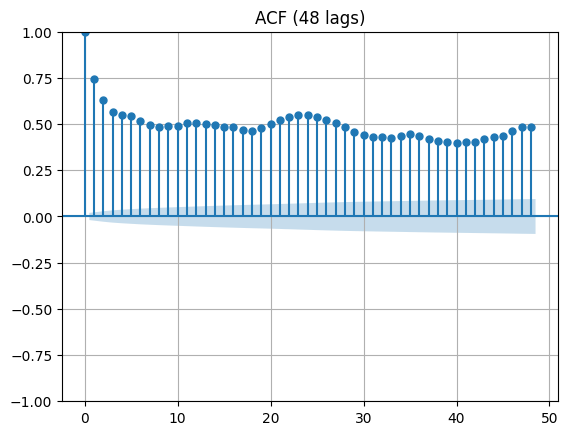


ACF spikes at short lags → suggests q candidates.


In [12]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plot_acf(series, lags=48)
plt.title("ACF (48 lags)")
plt.grid(True)
plt.show()

print("\nACF spikes at short lags → suggests q candidates.")


3.7.5 PACF Plot (Verify p)

<Figure size 1000x400 with 0 Axes>

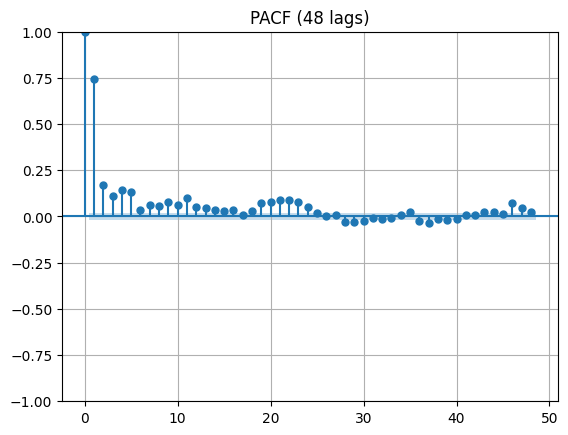


 PACF spikes at short lags → suggests p candidates.


In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10,4))
plot_pacf(series, lags=48, method="ywm")
plt.title("PACF (48 lags)")
plt.grid(True)
plt.show()

print("\n PACF spikes at short lags → suggests p candidates.")


3.7.6 Seasonal ACF (Find P,Q and check daily seasonality)

<Figure size 1000x400 with 0 Axes>

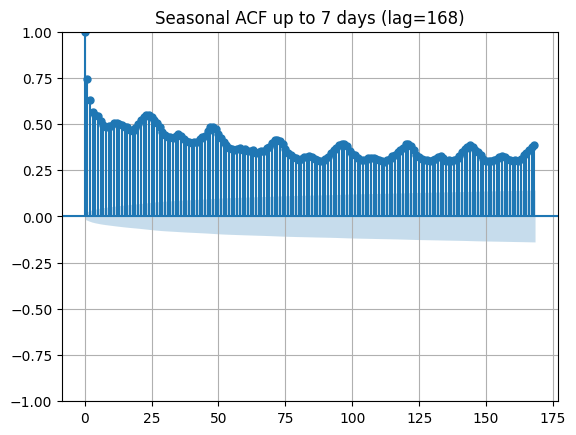

In [14]:
plt.figure(figsize=(10,4))
plot_acf(series, lags=24*7)
plt.title("Seasonal ACF up to 7 days (lag=168)")
plt.grid(True)
plt.show()

3.7.7 Grid search SARIMAX

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

print("=== Running FAST SARIMAX Grid-search (16 models) ===")

p = [0,1]
d = [0]
q = [0,1]

P = [0,1]
D = [1]                            
Q = [0,1]

s = 24

results_fast = []

for order in product(p, d, q):
    for seas in product(P, D, Q):
        seasonal_order = (seas[0], seas[1], seas[2], s)

        try:
            model = SARIMAX(
                y_train,
                exog=exog_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            pred = model.get_forecast(len(y_val), exog=exog_val).predicted_mean
            rmse = np.sqrt(mean_squared_error(y_val, pred))
            mae = mean_absolute_error(y_val, pred)

            results_fast.append([
                order, seasonal_order, model.aic, mae, rmse
            ])

            print(f"SARIMAX{order}x{seasonal_order} → RMSE={rmse:.2f}, AIC={model.aic:.1f}")

        except Exception as e:
            print(f"Skip {order}x{seasonal_order}: {e}")
            continue

df_fast = pd.DataFrame(results_fast, columns=['order','seasonal_order','AIC','MAE','RMSE'])
df_fast_sorted = df_fast.sort_values(['RMSE','AIC']).reset_index(drop=True)

print("\n=== TOP FAST SARIMAX MODELS ===")
df_fast_sorted.head(10)


=== Running FAST SARIMAX Grid-search (16 models) ===
SARIMAX(0, 0, 0)x(0, 1, 0, 24) → RMSE=129.37, AIC=98403.0
SARIMAX(0, 0, 0)x(0, 1, 1, 24) → RMSE=77.03, AIC=94858.3
SARIMAX(0, 0, 0)x(1, 1, 0, 24) → RMSE=107.63, AIC=97330.3
SARIMAX(0, 0, 0)x(1, 1, 1, 24) → RMSE=77.83, AIC=94852.1
SARIMAX(0, 0, 1)x(0, 1, 0, 24) → RMSE=135.63, AIC=98029.0
SARIMAX(0, 0, 1)x(0, 1, 1, 24) → RMSE=77.16, AIC=94798.4
SARIMAX(0, 0, 1)x(1, 1, 0, 24) → RMSE=110.93, AIC=97202.5
SARIMAX(0, 0, 1)x(1, 1, 1, 24) → RMSE=79.91, AIC=94782.3
SARIMAX(1, 0, 0)x(0, 1, 0, 24) → RMSE=138.90, AIC=97783.2
SARIMAX(1, 0, 0)x(0, 1, 1, 24) → RMSE=85.01, AIC=94538.5
SARIMAX(1, 0, 0)x(1, 1, 0, 24) → RMSE=116.75, AIC=96951.5
SARIMAX(1, 0, 0)x(1, 1, 1, 24) → RMSE=88.64, AIC=94498.1
SARIMAX(1, 0, 1)x(0, 1, 0, 24) → RMSE=141.19, AIC=97750.2
SARIMAX(1, 0, 1)x(0, 1, 1, 24) → RMSE=121.93, AIC=94095.9
SARIMAX(1, 0, 1)x(1, 1, 0, 24) → RMSE=142.97, AIC=96748.7
SARIMAX(1, 0, 1)x(1, 1, 1, 24) → RMSE=145.73, AIC=94193.1

=== TOP FAST SARIMAX MOD

,order,seasonal_order,AIC,MAE,RMSE
0,"(0, 0, 0)","(0, 1, 1, 24)",94858.322597,57.835587,77.026248
1,"(0, 0, 1)","(0, 1, 1, 24)",94798.422046,58.291655,77.161099
2,"(0, 0, 0)","(1, 1, 1, 24)",94852.095290,58.756688,77.825762
3,"(0, 0, 1)","(1, 1, 1, 24)",94782.261982,61.307045,79.911782
4,"(1, 0, 0)","(0, 1, 1, 24)",94538.511853,64.433891,85.012099
5,"(1, 0, 0)","(1, 1, 1, 24)",94498.059464,68.089376,88.641475
6,"(0, 0, 0)","(1, 1, 0, 24)",97330.338370,78.381686,107.632024
7,"(0, 0, 1)","(1, 1, 0, 24)",97202.510345,79.371773,110.925212
8,"(1, 0, 0)","(1, 1, 0, 24)",96951.506892,82.921739,116.746839
9,"(1, 0, 1)","(0, 1, 1, 24)",94095.914847,91.248804,121.925110


Conclusion: Best model = SARIMAX(0,0,0) × (0,1,1,24)

3.7.8 Refit the best model on Train+Validation

In [17]:
best_order = (0,0,0)
best_seasonal = (0,1,1,24)

model_final = SARIMAX(
    series.iloc[:val_end],                  
    exog = exog.iloc[:val_end],
    order = best_order,
    seasonal_order = best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(model_final.summary())


                                 SARIMAX Results                                  
Dep. Variable:               active_power   No. Observations:                 9100
Model:             SARIMAX(0, 1, [1], 24)   Log Likelihood              -53236.282
Date:                    Fri, 28 Nov 2025   AIC                         106490.565
Time:                            10:44:18   BIC                         106554.561
Sample:                                 0   HQIC                        106512.335
                                   - 9100                                         
Covariance Type:                      opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp            1.6294      0.324      5.028      0.000       0.994       2.265
humidity        0.1166      0.073      1.596      0.111      -0.027       0.260
pressure        

3.7.9 Forecast Test

In [19]:
pred_test = model_final.get_forecast(
    steps=len(y_test),
    exog=exog_test
)

y_pred = pred_test.predicted_mean
conf = pred_test.conf_int()

y_pred.index = y_test.index          
conf.index = y_test.index            

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n=== SARIMAX TEST PERFORMANCE ===")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")



=== SARIMAX TEST PERFORMANCE ===
MAE  = 54.37
RMSE = 71.23
MAPE = 30.23%


3.7.10 Plot Forecast

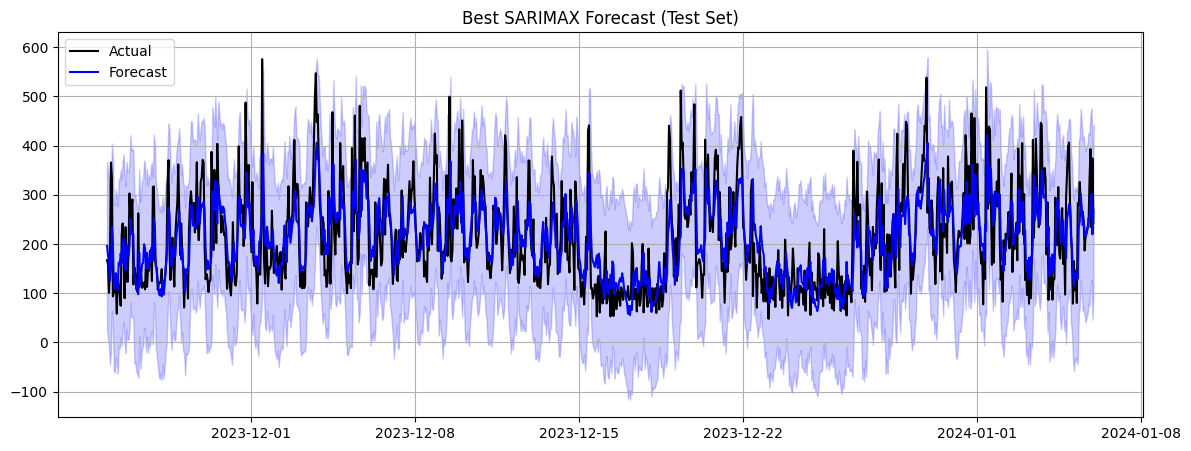

In [20]:
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual", color="black")
plt.plot(y_pred.index, y_pred, label="Forecast", color="blue")
plt.fill_between(
    y_pred.index,
    conf.iloc[:,0], conf.iloc[:,1],
    color="blue", alpha=0.2
)
plt.title("Best SARIMAX Forecast (Test Set)")
plt.legend()
plt.grid(True)
plt.show()
